# Final Functions
(for predicting masks)

## Function 1

- Should include entire pipeline, from data preprocessing to making final predictions.
- It should take in raw data as input.
- It should return predictions for your input. Here the input can be a single point or a set of points.
- def final_fun_1(X):
.....
.....
..... # 
- you will use the best model that you found out with your experiments
return predictions made on X ( Raw Data)

#### Function takes input in form of a list with two elements. First is the image whose mask is to be predicted, the second is the depth at which it was the image was taken.

In [1]:
def final_fun_1(X):
    import tensorflow as tf
    import pandas as pd
    import cv2
    import numpy as np
    import os
    
    model=tf.keras.models.load_model("model.h5")
    
    def pred_image(arr,threshold=0.5):
        res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
        for i,j in enumerate(arr):
            final_image=j[:,:,0]
            final_image=prob_to_image(final_image,threshold=threshold)
            res[i]=final_image
        return res
    
    def prob_to_image(arr,threshold=0.5):
        for i in range(len(arr)):
            for j in range(len(arr)):
                if arr[i,j]>threshold:
                    arr[i,j]=1
                else:
                    arr[i,j]=0
        return arr
    image = cv2.copyMakeBorder(X[0], 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
    image=np.stack([image,np.full((128,128),X[1])],axis=2)
    image=model.predict(np.expand_dims(image,0),verbose=0)
    image=image[:,13:114,13:114]

    return pred_image(image,threshold=0.5)[0]

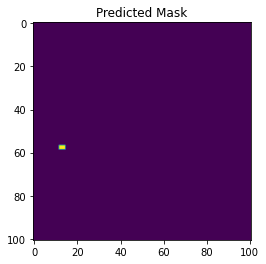

In [4]:
#loading libraries necessary to read the image files.
import cv2,pandas as pd,matplotlib.pyplot as plt,numpy as np

#reading dataframe made in earlier notebook
data=pd.read_csv("dataset.csv")

#selecting any random image
random_data_point=np.random.randint(0,4000)

#reading image
image=cv2.imread(data["img_path"][random_data_point],cv2.IMREAD_GRAYSCALE)

#saving image depth
depth=data["depth"][random_data_point]

#predicting mask
mask=final_fun_1([image,depth])

#showing the mask
plt.title("Predicted Mask")
plt.imshow(mask)
plt.show()

## Function:2
- Should include entire pipeline, from data preprocessing to making final predictions.
- It should take in raw data as input along with its target values.
- It should return the metric value that you are judging your models on.
- def final_fun_2(X,Y):
- .....
- .....
- #you will use the best model that you found out with your experiments
- return final_metric computed on X ( Raw Data) and Y (target variable)

#### Similar to Function 1, Raw Data is inputted in form of a list with two elements. First is the image whose mask is to be predicted, the second is the depth at which it was the image was taken.  The target variable should be the actual mask of the image.

In [2]:
def final_fun_2(X,Y):
    import tensorflow as tf
    import pandas as pd
    import cv2
    import numpy as np
    import os
    
    model=tf.keras.models.load_model("model.h5")
    
    def pred_image(arr,threshold=0.5):
        res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
        for i,j in enumerate(arr):
            final_image=j[:,:,0]
            final_image=prob_to_image(final_image,threshold=threshold)
            res[i]=final_image
        return res
    
    def prob_to_image(arr,threshold=0.5):
        for i in range(len(arr)):
            for j in range(len(arr)):
                if arr[i,j]>threshold:
                    arr[i,j]=1
                else:
                    arr[i,j]=0
        return arr
    image = cv2.copyMakeBorder(X[0], 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
    image=np.stack([image,np.full((128,128),X[1])],axis=2)
    image=model.predict(np.expand_dims(image,0),verbose=0)
    image=image[:,13:114,13:114]
    
    #declaring metric
    iou=tf.keras.metrics.BinaryIoU()
    
    iou_score=iou(mask,pred_image(image,threshold=0.5)[0])
    
    return np.array(iou_score)

<center><h1>Visualizing Training Results</h1></center>

In [36]:
from tqdm import tqdm
validation=pd.read_csv("validation.csv")
ious=[]
depths=[]
salt_coverage=[]
for i in tqdm(range(len(validation["img_path"]))):
    image=cv2.imread(data["img_path"][i],cv2.IMREAD_GRAYSCALE)
    depth=data["depth"][i]
    depths.append(depth)
    mask=cv2.imread(data["mask_path"][i],cv2.IMREAD_GRAYSCALE)
    mask=mask//255
    salt_coverage.append(np.mean(mask))
    ious.append(final_fun_2([image,depth],mask))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [14:36<00:00,  2.19s/it]


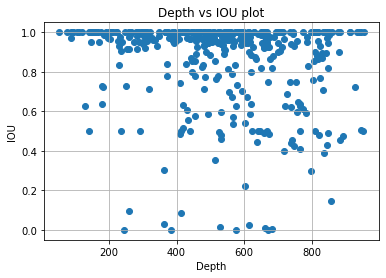

In [46]:
plt.title("Depth vs IOU plot")
plt.scatter(depths,ious)
plt.xlabel("Depth")
plt.ylabel("IOU")
plt.grid()
plt.show()

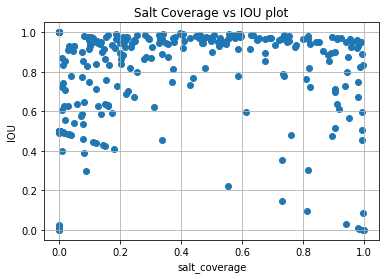

In [47]:
plt.title("Salt Coverage vs IOU plot")
plt.scatter(salt_coverage,ious)
plt.ylabel("IOU")
plt.xlabel("salt_coverage")
plt.grid()
plt.show()

# Observation:
- The density of datapoints with low salt_coverage is higher in lower IOU regions
- No visible pattern in Depth vs Iou plot

# Idea:1
# Binary Mask Classifier
Developing a model (Classifier) to detect images with no Mask and mark them as such before predicting using the main segmentation model

In [ ]:
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1= channel_spatial_squeeze_excite(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------    
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2= channel_spatial_squeeze_excite(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 
#-----------------------------------------------------------------------------------------------------------------    
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3= channel_spatial_squeeze_excite(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4= channel_spatial_squeeze_excite(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = tf.keras.layers.Flatten()(c5)
    outputs=Dense(1,activation="sigmoid")(c5)

    model = Model(input_img, outputs)
    return model
input_img = Input((128, 128, 2), name='img')
model = UNet(input_img)

<img src=https://i.imgur.com/gTFhh83.png>

## Results
Though the classifier did produce results with validation accuracy of 85%, the results worsened
<img src=https://i.imgur.com/TmeAlbS.jpg>

# Idea:2
# Ensemble of Models

- Tried to create an ensemble of models trained on stratified 5-fold data.
- Each model trained for 200 epochs- 100 with binary cross entropy as the loss and 100 with jaccard distance

In [37]:
import os

listt=os.listdir("test/images")
def clean_mask(arr):
    temp=np.nonzero(arr)
        
    for i in range(temp[0].shape[0]):
        arr[temp[0][i],temp[1][i]]=1
    return arr

def pred_image(arr,threshold=0.5):
    res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for i,j in enumerate(arr):
        final_image=j[:,:,0]
        final_image=prob_to_image(final_image,threshold=threshold)
        res[i]=final_image
    return res
def prob_to_image(arr,threshold=0.5):
    for i in range(len(arr)):
        for j in range(len(arr)):
            if arr[i,j]>threshold:
                arr[i,j]=1
            else:
                arr[i,j]=0
    return arr
from tqdm import tqdm
def mask_to_rle(arr):
    arr=clean_mask(arr)
    pos_pixels=[]
    count=1
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[j,i]==1:
                pos_pixels.append(count)
            count+=1
    if len(pos_pixels)==0:
        return ""
    rle=""
    is_cons=[False]
    for i in range(len(pos_pixels)-1):
        if pos_pixels[i+1]-pos_pixels[i]==1:
            is_cons.append(True)
        else:
            is_cons.append(False)
    count=1
    for i in range(len(pos_pixels)):
        if is_cons[i]==False:
            rle+=" "+str(count)+" "+str(pos_pixels[i])
            count=1
        elif is_cons[i]==True:
            count+=1
    rle+=" "+str(count)
    return rle[3:]

idd=[]
rle=[]
for i in tqdm(os.listdir("predictions/model0")):
    idd.append(i[:10])
    
    image=cv2.imread("predictions/model0/"+i,cv2.IMREAD_GRAYSCALE)/255
    image+=(cv2.imread("predictions/model1/"+i,cv2.IMREAD_GRAYSCALE)/255)
    image+=(cv2.imread("predictions/model2/"+i,cv2.IMREAD_GRAYSCALE)/255)
    image+=(cv2.imread("predictions/model3/"+i,cv2.IMREAD_GRAYSCALE)/255)
    image/=4

    image=pred_image(np.expand_dims(np.expand_dims(image,0),-1),threshold=0.5)[0]
    rle.append(mask_to_rle(image))
m=pd.DataFrame()
m["id"]=idd
m["rle_mask"]=rle
m.to_csv("ensemble.csv",index=False)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [03:39<00:00, 81.83it/s]


<img src=https://i.imgur.com/1NNInqy.jpg>

## Observations:
Ensemble Models performed poorly which may be attributed to the less training period. Training for the best model submitted earlier involved training for almost 100 epochs on Binary Cross Entropy and 350 epochs on Jaccard Distance. Training for 200 epochs itself results in training period of almost 40 minutes for each model in ensemble, which amounted to almost 3.5 hrs for the whole ensemble. Training for 250 epochs more on Jaccard Distance will result in training period of more than 3.5 hrs. Dont know whether a Colab instance can last that long